In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import h5py

def get_aggprop(h5dict: h5py._hl.files.File, property: str):
    """
    Get the bundles statistics on whole brain level from the HDF5 file.

    Parameters
    ----------
    h5dict : h5py._hl.files.File 
        The opened HDF5 file.
    property : str
        The property to extract from the HDF5 file.

    Returns
    -------
    ret : np.arrasy
        The array containing the requested property values.
    """

    try:
        ret = np.array(h5dict.get("matrices").get(property))
    except:
        print("Not valid property OR h5 not opened")
    return ret

## F-tract and Probabilistic atlas comparison

Contents:
- Sanity check (not passed)
    - F-tract pairs of regions measured but with 0 probability consistent with atlas not having a bundle?

In [4]:
# data_path = "/Users/acionca/data/"
data_path = "/Users/mikichan/Desktop/mywork/atlas_data/f-tract_v2112/"

max_delay = 400

proba_file = op.join(data_path, f'F-TRACT-090624/{max_delay}/probability.txt.gz')
delay_file = op.join(data_path, f'F-TRACT-090624/{max_delay}/peak_delay__median.txt')
region_file = op.join(data_path, f'F-TRACT-090624/Lausanne2008-33.txt')

proba_array = np.genfromtxt(proba_file, delimiter=' ')
proba_array = np.array(proba_array).astype(float)
#proba_array = (proba_array + proba_array.T)/2

In [6]:
scale = 1
connFilename = f'../../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5'
# connFilename = op.join(data_path, f'atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale{scale}.h5')
hf = h5py.File(connFilename, 'r')

centers = np.array(hf.get('header').get('gmcoords'))

gmregions_names = hf.get('header').get('gmregions')[()]
nb_regions = gmregions_names.shape[0]
consistency_view = get_aggprop(hf, 'consistency')


array1 = gmregions_names
array1 = [a.decode('utf-8').lower() for a in array1]

with open(region_file) as f:
    array2 = f.readlines()

array2 = [regionname.replace('.','-').lower().strip() for k, regionname in enumerate(array2)]
for sidx, region in enumerate(array2):
    if 'right' in region:
        array2[sidx] = region.replace('right','rh')
    if 'left' in region:
        array2[sidx] = region.replace('left','lh')

In [30]:
match_indexes = np.zeros(len(array2)) - 1
for k in range(len(array2)):
    for sidx, searchname in enumerate(array1):
        if array2[k] in searchname:
            match_indexes[k] = sidx
        if 'lh-accumbens-area' in array2[k]:
            if 'lh-accumbens' in searchname:
                match_indexes[k] = sidx
        if 'rh-accumbens-area' in array2[k]:
            if 'rh-accumbens' in searchname:
                match_indexes[k] = sidx
                
rightth = np.where(['thal' in tmp for tmp in array1])[0][:7]
leftth = np.where(['thal' in tmp for tmp in array1])[0][7:]

In [31]:
struct_conn = consistency_view / consistency_view.max()
struct_conn -= np.diag(np.diag(struct_conn))

In [37]:
fibers_array = np.zeros_like(proba_array)
for ridx in range(len(fibers_array)):
    for cidx in range(len(fibers_array)):
        
        if (ridx == 83) or (cidx == 83):
            fibers_array[ridx, cidx] = np.nan
        else:
            if ridx == 34 and cidx == 34: fibers_array[ridx, cidx] = struct_conn[rightth][:, rightth].mean()
            elif ridx == 34 and cidx == 75: fibers_array[ridx, cidx] = struct_conn[rightth][:, rightth].mean()
            elif ridx == 75 and cidx == 34: fibers_array[ridx, cidx] = struct_conn[rightth][:, rightth].mean()
            elif ridx == 75 and cidx == 75: fibers_array[ridx, cidx] = struct_conn[rightth][:, rightth].mean()
            else:
                fibers_array[ridx, cidx] = struct_conn[int(match_indexes[ridx]), int(match_indexes[cidx])]

utils.save(f'../resources/bundle_probability_atlas-d{max_delay}.pkl', fibers_array)
utils.save(f'../resources/adj_probability_ftract-d{max_delay}.pkl', proba_array)

In [38]:
mask1 = np.isnan(proba_array)
mask2 = np.isnan(fibers_array)

proba_array[mask1] = np.nan
proba_array[mask2] = np.nan
fibers_array[mask1] = np.nan
fibers_array[mask2] = np.nan
proba_array = proba_array - np.diag(np.diag(proba_array))

print(np.sum(mask1) / np.prod(proba_array.shape))

0.2662981859410431


(array([192.,  27.,  20.,  17.,  13.,   8.,   9.,  11.,  11.,  45.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

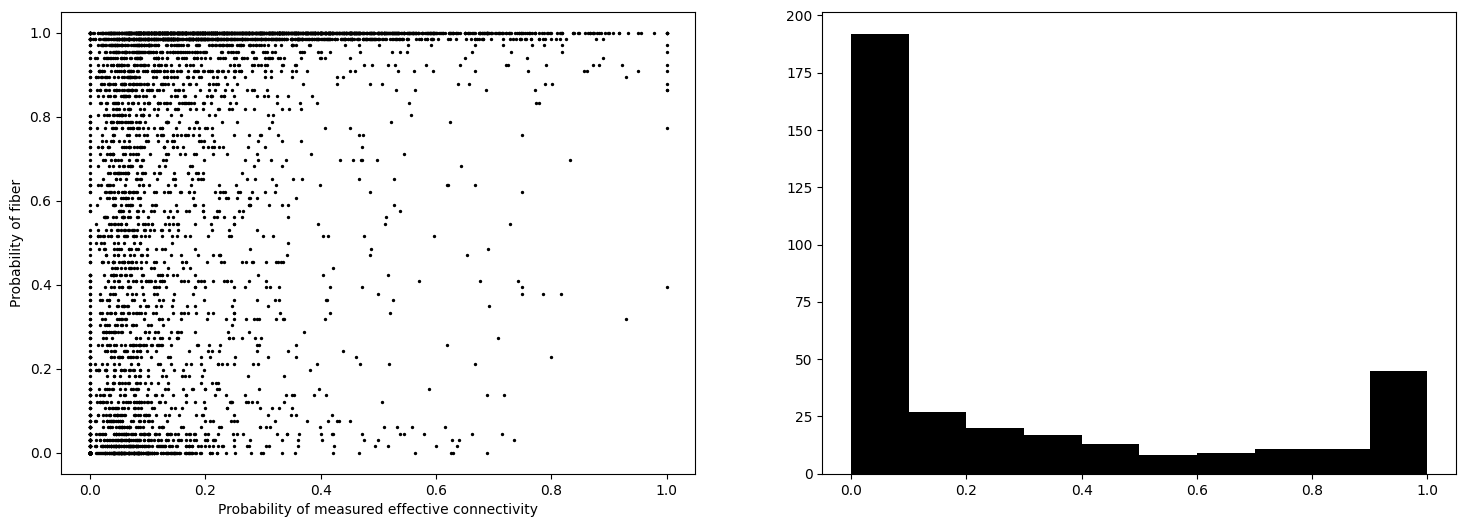

In [39]:
fig,ax = plt.subplots(1,2, figsize=(18,6))
ax[0].scatter(proba_array[~np.isnan(proba_array)], fibers_array[~np.isnan(fibers_array)], s=2, color='k')
ax[0].set_xlabel('Probability of measured effective connectivity')
ax[0].set_ylabel('Probability of fiber')

ax[1].hist(fibers_array[proba_array==0], color='k')

Text(0.5, 1.0, 'fiber probability')

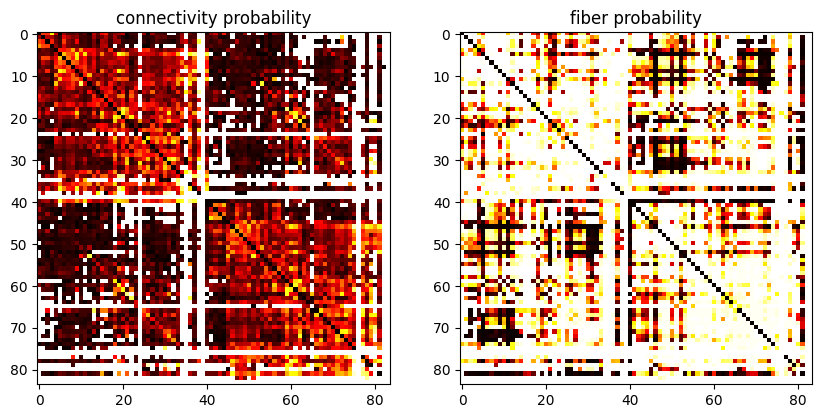

In [41]:
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(proba_array, cmap='hot')
ax[1].imshow(fibers_array, cmap='hot')
ax[0].set_title('connectivity probability')
ax[1].set_title('fiber probability')